In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams.update({'font.size':20})
plt.rcParams["figure.figsize"] = (10,6)

In [3]:
str_files = ''
#Carrega os dados do arquivo .csv
#df = pd.read_csv(str_files + "ph.csv",encoding='utf-8',sep=';')
dateparse = lambda dates:pd.datetime.strptime(dates,'%d/%m/%Y')
df = pd.read_csv(str_files + 'ph.CSV',encoding='utf-8',sep=';', parse_dates = ['data_coleta'],index_col=['data_coleta'],date_parser=dateparse)

/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


In [4]:
#Seleciona os dados da UGRHI 10 - SOROCABA/MEDIO TIETE
z = df.loc[df['UGRHI'] == '10 - SOROCABA/MEDIO TIETE']

In [5]:
#Agrupa os dados pela media bimestral
trainingd = z.resample('2M').mean()

In [6]:
trainingd
#Remove as colunas que não serão utilizadas no experimento.
trainingd = trainingd.drop(['cod_interaguas', 'sinal','Altitude'], axis=1)
trainingd


,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [7]:
#Regra 1.5*FIG --> Calcula-se o limite inferior e superior do diagrama de caixa.

#Ordena o dataframe
trainingds = trainingd.sort_values('valor',axis=0)

trainingds

tamanho = len(trainingds)
#Calcula o 1Q, ou seja, os primeiros 25% do diagrama de caixa.
primeiro_quartil = trainingds.quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear')
#Calcula o 3Q, ou seja, 75% do diagrama de caixa.
terceiro_quartil = trainingds.quantile(q=0.75, axis=0, numeric_only=True, interpolation='linear')

print('primeiro_quartil:',primeiro_quartil)
print('terceiro_quartil:',terceiro_quartil)

#Calcula-se o interquartil(FIQ).
fig = terceiro_quartil - primeiro_quartil
print('fig:',fig)

#Calcula o limite inferior.
inferior = primeiro_quartil - (1.5*fig)
#Calcula o limite superior.
superior = terceiro_quartil + (1.5*fig)

print('Inferior:',inferior)
print('Superior:',superior)

#Seleciona os valores abaixo  do limite inferior, ou seja, os outlier.
outlier = trainingd[(trainingds.valor < 6.34725)]

outlier


primeiro_quartil: valor    6.9
Name: 0.25, dtype: float64
terceiro_quartil: valor    7.2685
Name: 0.75, dtype: float64
fig: valor    0.3685
dtype: float64
Inferior: valor    6.34725
dtype: float64
Superior: valor    7.82125
dtype: float64


/home/anderson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,valor
data_coleta,
1987-01-31,6.2


In [8]:
#Substituição do outlier pelo valor médio da serie dos dados.
trainingd.loc[trainingd['valor'] == 6.20] = 7.08

outlier = trainingd[(trainingd.valor < 6.34725)]

outlier

,valor
data_coleta,


In [9]:
trainingd

,valor
data_coleta,
1978-01-31,7.100
1978-03-31,6.625
1978-05-31,6.650
1978-07-31,6.625
1978-09-30,6.575
...,...
2018-07-31,7.266
2018-09-30,7.250
2018-11-30,7.244


In [10]:
#Dados completo.
data = trainingd.iloc[:,:].values
#treino (70%)
train = trainingd.iloc[0:174,:].values  
#teste (30%)
test = trainingd.iloc[174:,:].values 

print('Completo:',len(data))
print('treino:',len(train))
print('teste:',len(test))
data.shape

Completo: 248
treino: 174
teste: 74


(248, 1)

In [11]:
#Normalização dos dados: Normaliza os dados dentro um intervalo (-1 a 1).
sc = MinMaxScaler()
train = sc.fit_transform(train)
test = sc.fit_transform(test)


In [12]:
#Prepara o conjunto de dados em X e y, considerando a janela de visualização (lags).
def prepara_dados(dados,lags):
    X = []
    y = []
    for i in range(lags, len(dados)):
        X.append(dados[i-lags:i, 0])
        y.append(dados[i, 0])
    return np.array(X), np.array(y)

#Calcula o MAPE
#Define função para calcular o MAPE
#def mape(y_pred,y_true):
 #   return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mape(y_pred,y_true):
    mape_sum = 0
    for real,prediction in zip(y_true,y_pred):
        mape_sum += (abs((real - prediction))/real)
        mape = mape_sum/len(real)
    return mape

def rmse(y_pred,y_true):
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    return rmse

In [14]:
lags = 87 # Equivalente à 50% dos dados de treino.
#Prepara os dados de treinamento
train_X, train_y = prepara_dados(train, lags)
    
#Prepara os dados de teste
entradas = trainingd[len(trainingd) - len(test) - lags:].values
entradas = entradas.reshape(-1, 1)
entradas = sc.fit_transform(entradas)

test_X = []
for i in range(lags, lags+len(test)):
    test_X.append(entradas[i-lags:i, 0])
test_X = np.array(test_X)
    
#Cria o modelo

model = Sequential()
model.add(Dense(units = 10, activation = 'relu', input_dim = lags))
model.add(Dense(units = 21, activation = 'relu'))
model.add(Dense(units = 1, activation = 'linear'))
model.compile(loss = 'mean_absolute_error', optimizer = 'adam',
                  metrics = ['mean_absolute_error'])

#Treina o modelo
model.fit(train_X, train_y, batch_size = 32, epochs = 100)
#score = model.score(train_X,train_y)
#print(score)

#Dados de teste
previsoes = model.predict(test_X)
previsoes = previsoes.reshape(-1, 1)
previsoes = sc.inverse_transform(previsoes)

#Dados de treino
previsoes_treino = model.predict(train_X)
previsoes_treino = previsoes_treino.reshape(-1, 1)
previsoes_treino = sc.inverse_transform(previsoes_treino)



Train on 87 samples
Epoch 1/100
87/87 [==============================] - 0s 4ms/sample - loss: 0.6927 - mean_absolute_error: 0.6927
Epoch 2/100
87/87 [==============================] - 0s 145us/sample - loss: 0.6113 - mean_absolute_error: 0.6113
Epoch 3/100
87/87 [==============================] - 0s 96us/sample - loss: 0.5503 - mean_absolute_error: 0.5503
Epoch 4/100
87/87 [==============================] - 0s 105us/sample - loss: 0.4899 - mean_absolute_error: 0.4899
Epoch 5/100
87/87 [==============================] - 0s 97us/sample - loss: 0.4130 - mean_absolute_error: 0.4130
Epoch 6/100
87/87 [==============================] - 0s 103us/sample - loss: 0.3259 - mean_absolute_error: 0.3259
Epoch 7/100
87/87 [==============================] - 0s 117us/sample - loss: 0.2376 - mean_absolute_error: 0.2376
Epoch 8/100
87/87 [==============================] - 0s 93us/sample - loss: 0.1574 - mean_absolute_error: 0.1574
Epoch 9/100
87/87 [==============================] - 0s 92us/sample - los

87/87 [==============================] - 0s 115us/sample - loss: 0.0804 - mean_absolute_error: 0.0804
Epoch 72/100
87/87 [==============================] - 0s 155us/sample - loss: 0.0772 - mean_absolute_error: 0.0772
Epoch 73/100
87/87 [==============================] - 0s 132us/sample - loss: 0.0782 - mean_absolute_error: 0.0782
Epoch 74/100
87/87 [==============================] - 0s 124us/sample - loss: 0.0760 - mean_absolute_error: 0.0760
Epoch 75/100
87/87 [==============================] - 0s 128us/sample - loss: 0.0759 - mean_absolute_error: 0.0759
Epoch 76/100
87/87 [==============================] - 0s 152us/sample - loss: 0.0753 - mean_absolute_error: 0.0753
Epoch 77/100
87/87 [==============================] - 0s 137us/sample - loss: 0.0749 - mean_absolute_error: 0.0749
Epoch 78/100
87/87 [==============================] - 0s 131us/sample - loss: 0.0747 - mean_absolute_error: 0.0747
Epoch 79/100
87/87 [==============================] - 0s 117us/sample - loss: 0.0745 - mean_a

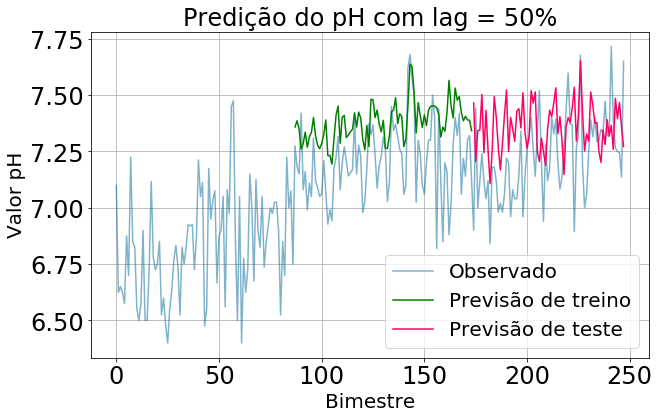

Resultados com lag 87


MAPE TREINO: 0.68 %
RMSE TREINO: 0.1


MAPE TESTE: 33.0 %
RMSE TESTE: 5.93




In [16]:
#Preparação para plotagem
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[lags: len(previsoes_treino) + lags, :] = previsoes_treino
train_predict_plot.shape
    
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(previsoes_treino)+lags:len(data), :] = previsoes

#Plotagem do gráfico
plt.plot(data, color = '#006699',alpha=0.5, label = 'Observado')
plt.plot(train_predict_plot, color = 'green', label = 'Previsão de treino')
plt.plot(test_predict_plot, color = '#ff0066', label = 'Previsão de teste')
plt.title('Predição do pH com lag = 50%')
plt.xlabel('Bimestre')
plt.ylabel('Valor pH')
plt.legend()
plt.grid()
plt.show()
    
#Calculo do erro da previsão
#mape(previsoes.mean(),test.mean())
test = sc.inverse_transform(test)
treino = sc.inverse_transform(train[lags: len(previsoes_treino) + lags, :])

print('Resultados com lag', lags)
print('\n')
print('MAPE TREINO:',round(mape(previsoes_treino,treino)[0],2),'%')
print('RMSE TREINO:',round(rmse(previsoes_treino,treino),2))
print('\n')
print('MAPE TESTE:',round(mape(previsoes,test)[0],2),'%')
print('RMSE TESTE:',round(rmse(previsoes,test),2))
print('\n')


(248, 1)

174